<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2024

#### 11220IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [ ]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np

In [15]:
from google.colab import drive
file_paths = glob.glob('/content/drive/MyDrive/人工智慧資料集/DL_HW3/test/*/*.png')
file_paths = sorted([path for path in file_paths if path.split('/')[-1] in [f'{i:03}.png' for i in range(16)]])

In [16]:
#把每一張圖讀出來
all_data = []

for img in tqdm(file_paths):
    img = cv2.imread(img)
    img = img[..., ::-1]
    all_data.append(img)

#把原本是list的資料轉成numpy
all_data = np.stack(all_data)
print(all_data.shape)

  0%|          | 0/96 [00:00<?, ?it/s]

(96, 1024, 1024, 3)


Classes: ['color', 'cut', 'fold', 'glue', 'good', 'poke']


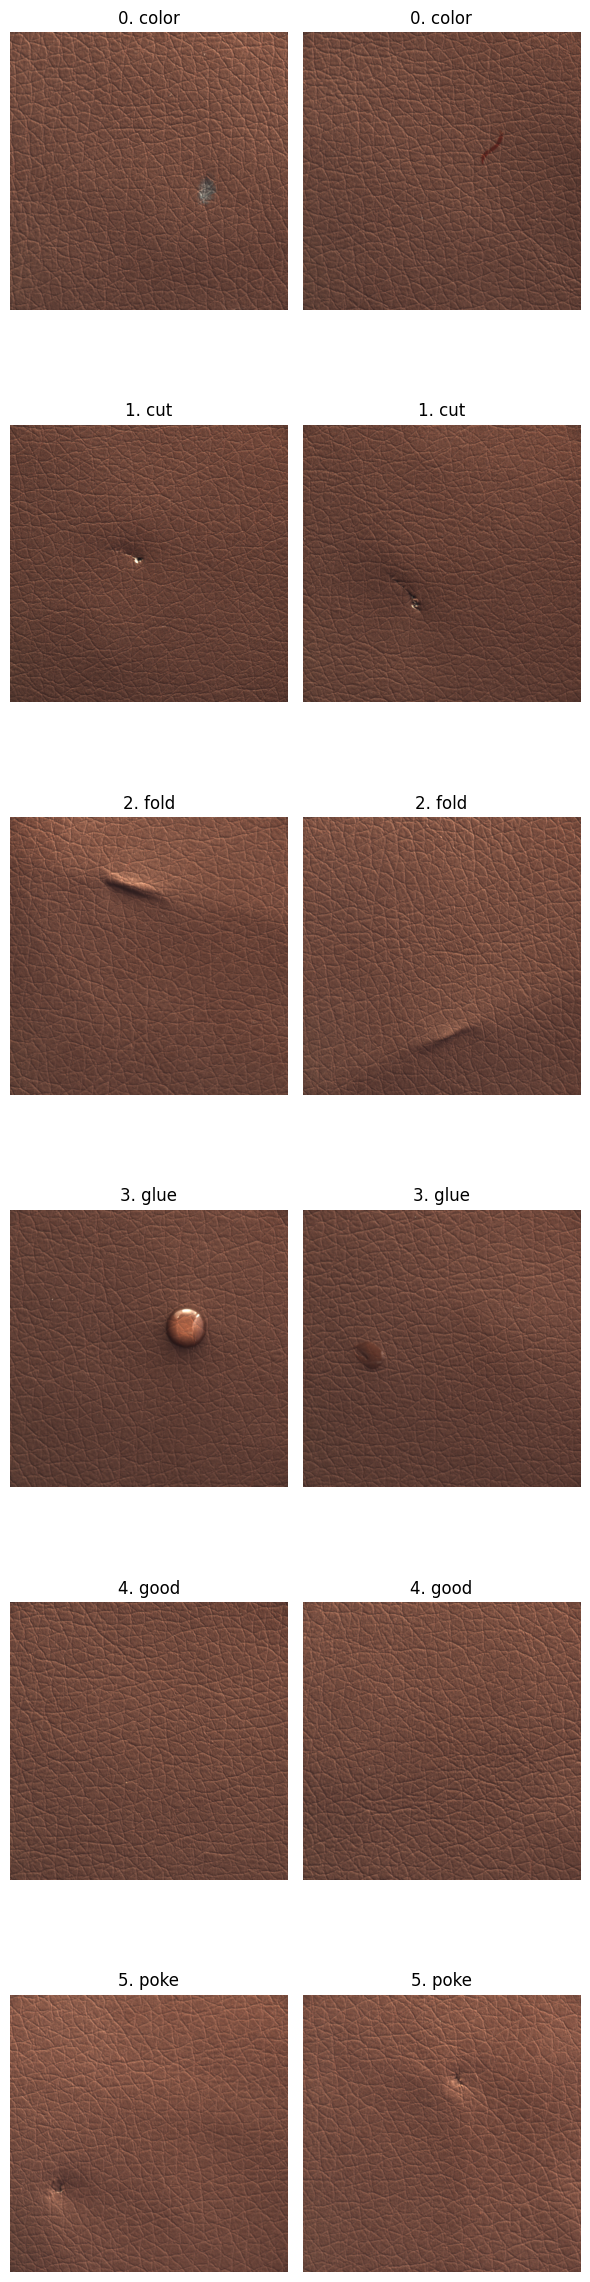

In [27]:
import matplotlib.pyplot as plt
import numpy as np

classes = sorted(set([path.split('/')[-2] for path in file_paths])) #因為已知此資料的命名規則所以才取出需要的資料欄位
print(f'Classes: {classes}')

images_per_class = len(all_data) // len(classes)
fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)))

for i, class_name in enumerate(classes):
    index = i * images_per_class
    for j in range(2):
        axs[i, j].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show() #印出資料

## A. Data Loading and Preprocessing

In [47]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

num_classes = 6
images_per_class = 16 #每一個class有幾張圖
train_images_per_class = int(images_per_class * 0.8)
val_images_per_class = int(images_per_class * 0.2)

x_train = []
x_val = []

for i in range(num_classes):
    start_index = i * images_per_class
    x_train.extend(all_data[start_index:start_index + train_images_per_class])
    x_val.extend(all_data[start_index + train_images_per_class:start_index + images_per_class])

#根據資料擺法調整，此處寫法是因應資料擺法是把一個類別擺完再擺下一個，然後取前8張訓練後2張test

# The shape changes from (batch_size, height, width, channels) to (batch_size, channels, height, width)
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))

y_train = np.concatenate([np.full(train_images_per_class, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(len(x_val) // num_classes, i) for i in range(num_classes)])

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}') #1024,1024指的是圖
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of x_train: (72, 3, 1024, 1024)
Shape of x_val: (24, 3, 1024, 1024)
Shape of y_train: (72,)
Shape of y_val: (24,)


In [77]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.AutoAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

#把1024x1024 resize 成32x32 #可改
#data augumentation
#totensor轉換資料

val_transforms = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ]
)

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long() #long為比較長的int
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0))
        return self.transform(Image.fromarray(new_x)), self.y[idx]

In [78]:
batch_size = 8

train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=1, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False,num_workers=1,  pin_memory=True, persistent_workers=True)

## B. Defining Neural Networks

In [79]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

model = models.wide_resnet50_2(weights='IMAGENET1K_V1') #copy pretrain的weight(resnet18)

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_class = 6 #因為已經知道是8類，但作業要自己找dataset要改

# change # of class from 1000 into 8 in the last layer
model.fc = nn.Linear(num_ftrs, num_class) #最後一層的名字可能不叫fc 要注意
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

## C. Training the Neural Network

In [80]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 100
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = (images) / 255. #normalize除最大值
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = (images) / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train loss: 1.7824, Train acc: 20.8333%, Val loss: 1.8001, Val acc: 16.6667%, Best Val loss: 1.8001 Best Val acc: 16.67%
Epoch 2/100, Train loss: 1.8202, Train acc: 9.7222%, Val loss: 1.8044, Val acc: 16.6667%, Best Val loss: 1.8001 Best Val acc: 16.67%
Epoch 3/100, Train loss: 1.7917, Train acc: 22.2222%, Val loss: 1.8047, Val acc: 16.6667%, Best Val loss: 1.8001 Best Val acc: 16.67%
Epoch 4/100, Train loss: 1.8010, Train acc: 19.4444%, Val loss: 1.7951, Val acc: 16.6667%, Best Val loss: 1.7951 Best Val acc: 16.67%
Epoch 5/100, Train loss: 1.7962, Train acc: 22.2222%, Val loss: 1.7874, Val acc: 12.5000%, Best Val loss: 1.7874 Best Val acc: 16.67%
Epoch 6/100, Train loss: 1.8365, Train acc: 12.5000%, Val loss: 1.8067, Val acc: 12.5000%, Best Val loss: 1.7874 Best Val acc: 16.67%
Epoch 7/100, Train loss: 1.7871, Train acc: 20.8333%, Val loss: 1.8572, Val acc: 20.8333%, Best Val loss: 1.7874 Best Val acc: 20.83%
Epoch 8/100, Train loss: 1.7758, Train acc: 20.8333%, Val loss:

### Visualizing model performance

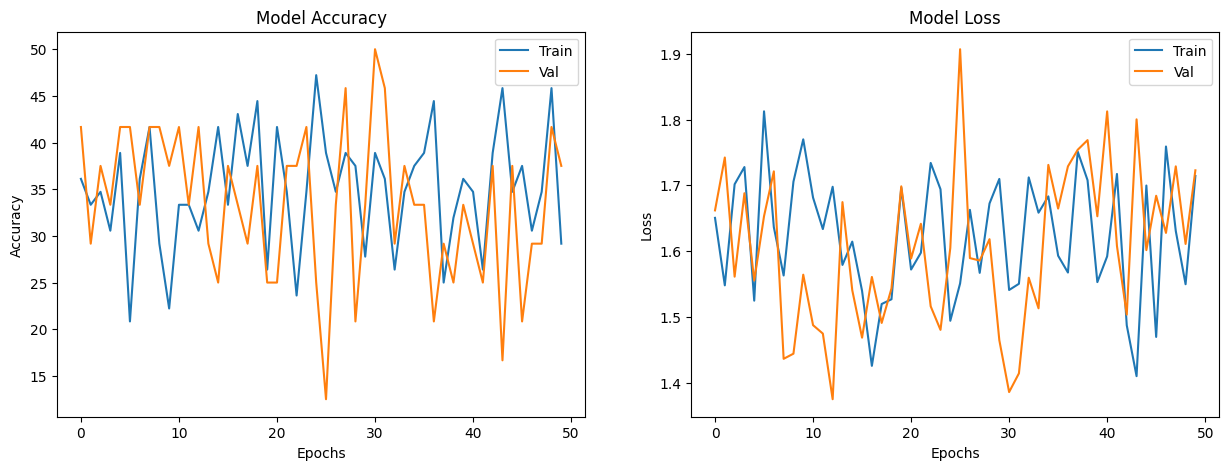

In [75]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [81]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:

        images = images.cuda()
        images = (images) / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

tensor([1, 4, 0, 2, 0, 1, 1, 1], device='cuda:0')
tensor([0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 2, 4, 3, 2, 3], device='cuda:0')
tensor([2, 2, 2, 2, 3, 3, 3, 3], device='cuda:0')
tensor([4, 1, 4, 4, 5, 5, 5, 5], device='cuda:0')
tensor([4, 4, 4, 4, 5, 5, 5, 5], device='cuda:0')
Test accuracy is 58.333333333333336%
